In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import warnings
from glob import glob
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')

In [2]:

# Download latest dataset
path = kagglehub.dataset_download("techsash/waste-classification-data")
train_path = os.path.join(path, "DATASET", "TRAIN")
test_path = os.path.join(path, "DATASET", "TEST")

# Data Preprocessing
x_data = []
y_data = []

100%|██████████| 427M/427M [00:19<00:00, 22.5MB/s]

Extracting files...


In [3]:
for category in glob(os.path.join(train_path, '*')):
    label = os.path.basename(category)  # Extract class name
    for file in tqdm(glob(os.path.join(category, '*'))):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(label)

data = pd.DataFrame({'image': x_data, 'label': y_data})
print("Dataset Shape:", data.shape)

100%|██████████| 12565/12565 [00:06<00:00, 1854.87it/s]

Dataset Shape: (22564, 2)


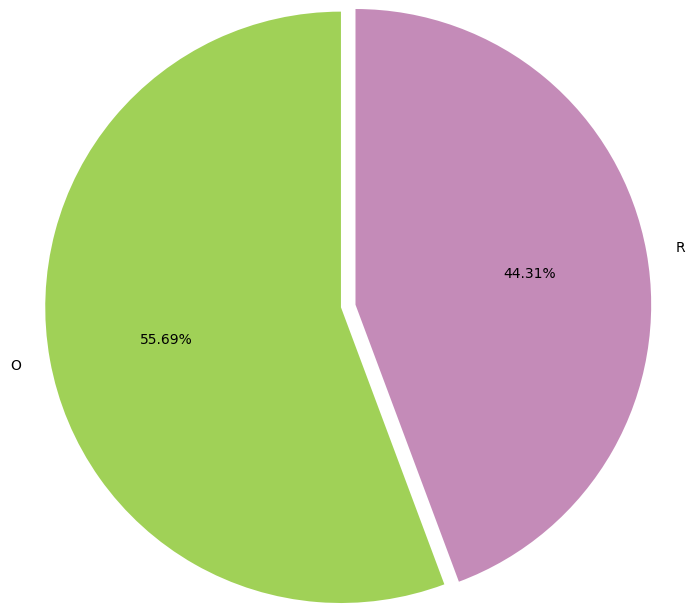

In [4]:
# Class Distribution Visualization
plt.pie(data['label'].value_counts().values,
        labels=data['label'].value_counts().index,
        startangle=90, explode=[0.05,0.05], autopct='%0.2f%%',
        colors=['#a0d157','#c48bb8'], radius=2)
plt.show()

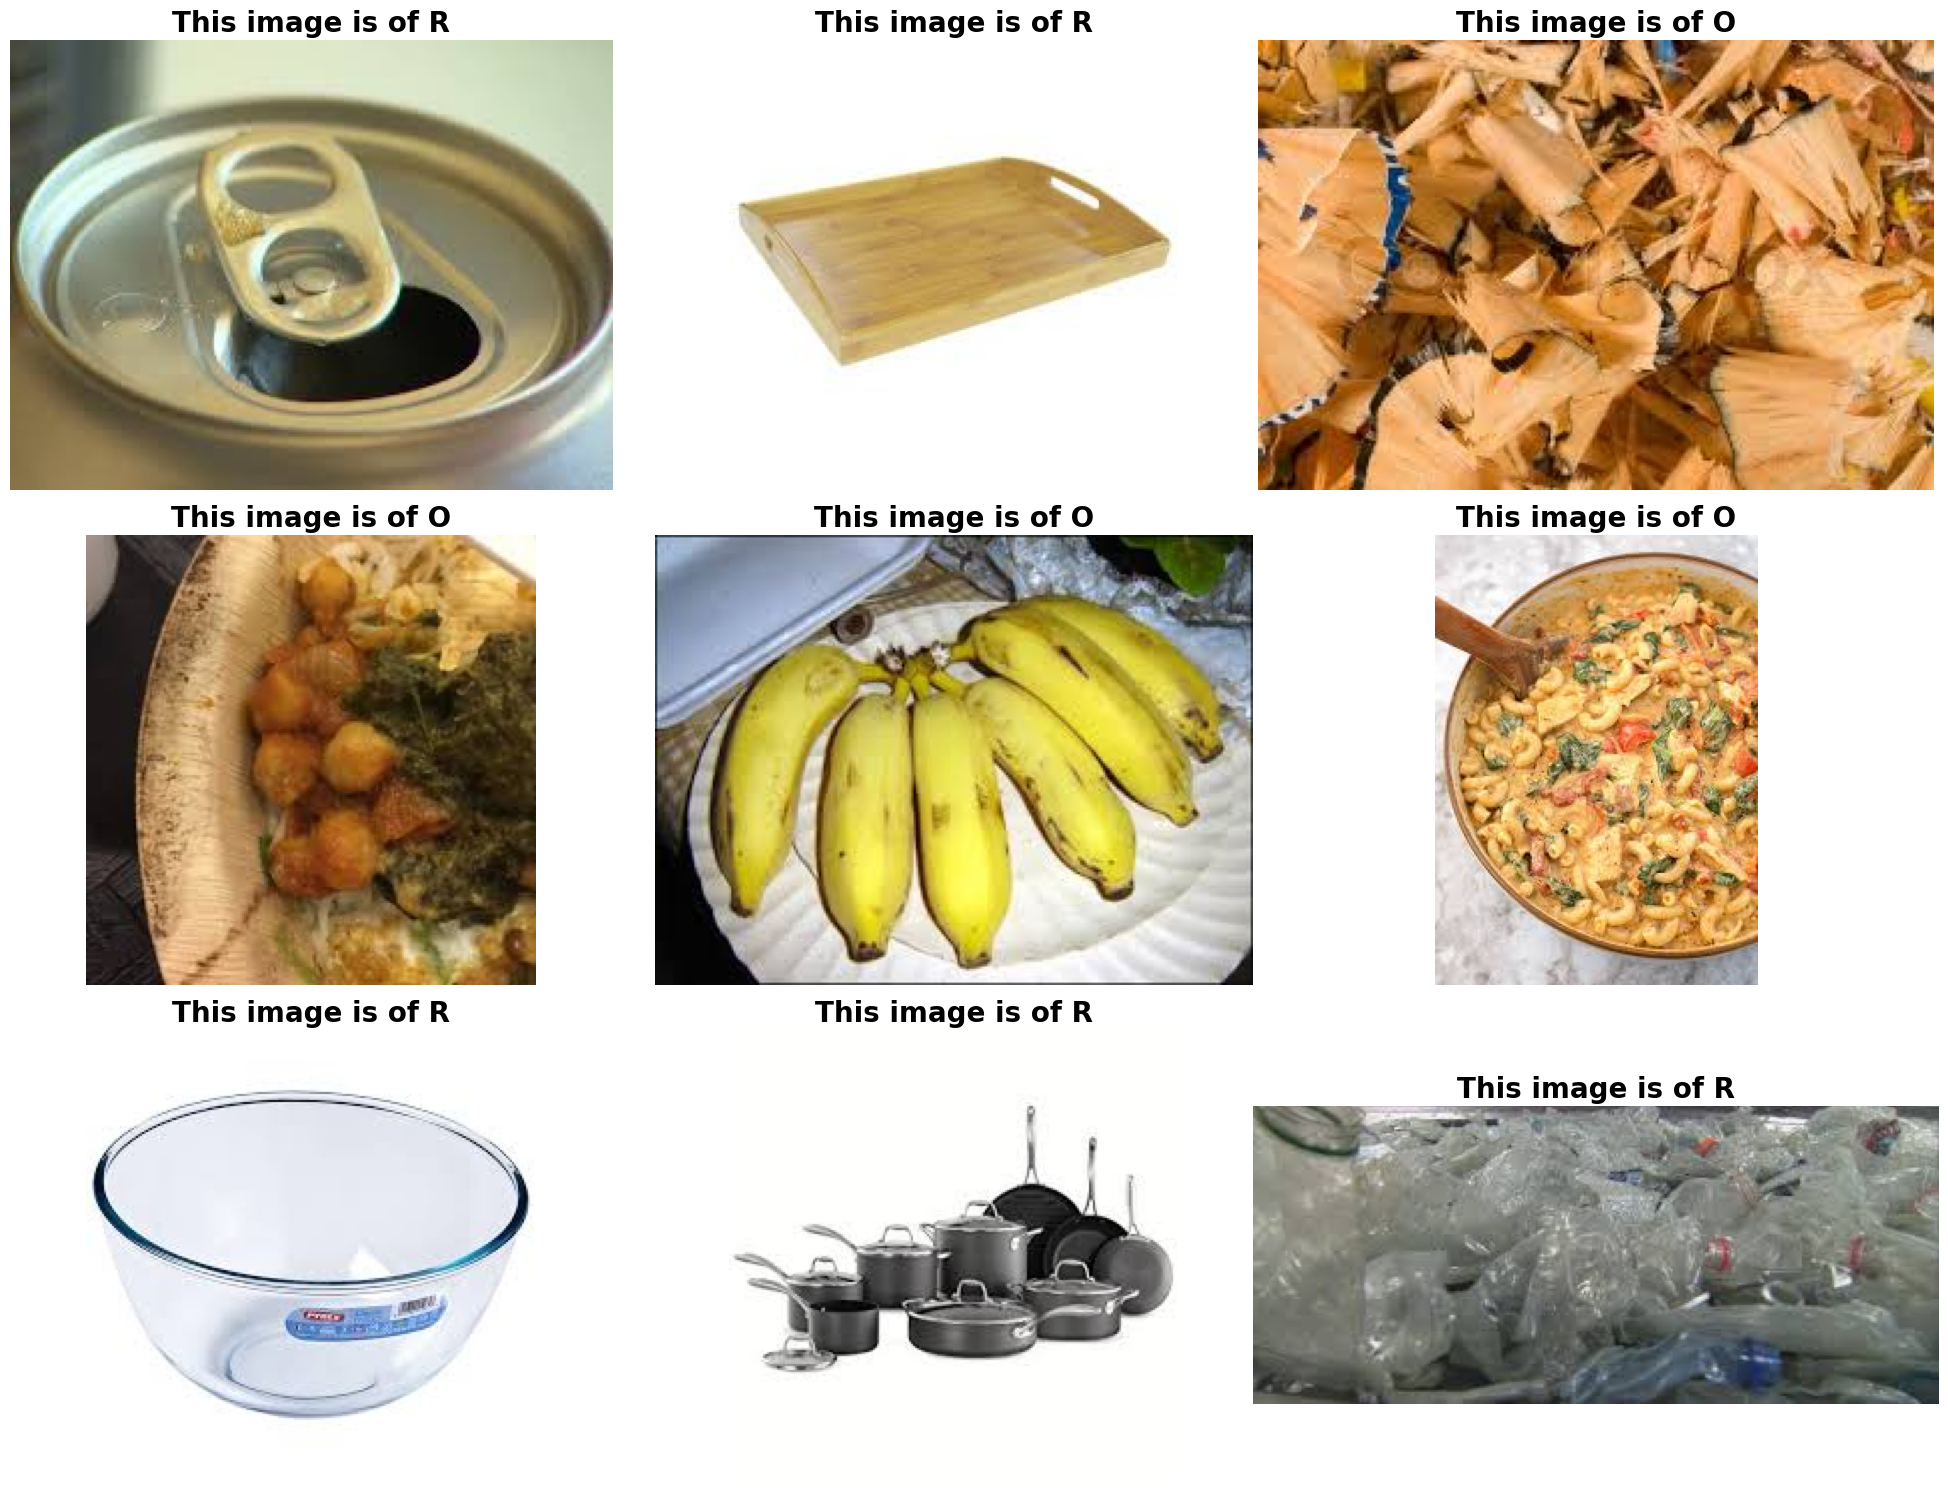

In [5]:
# Display Sample Images
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(len(data))
    plt.title(f'This image is of {data.label.iloc[index]}', fontdict={'size':20, 'weight':'bold'})
    plt.imshow(data.image.iloc[index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Model Definition
class_names = sorted(os.listdir(train_path))
number_of_classes = len(class_names)
print("Number of Classes:", number_of_classes)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Number of Classes: 2


In [7]:
# Display Model Summary & Structure
model.summary()
plot_model(model, show_shapes=True, to_file='model.png')

# Data Augmentation
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224,224), batch_size=batch_size, color_mode="rgb", class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
    test_path, target_size=(224,224), batch_size=batch_size, color_mode="rgb", class_mode="categorical")

# Model Training
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,250 (84.92 MB)

 Trainable params: 22,261,250 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 99s 816ms/step - accuracy: 0.6999 - loss: 0.7937 - val_accuracy: 0.8556 - val_loss: 0.3495
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 53s 592ms/step - accuracy: 0.8284 - loss: 0.4076 - val_accuracy: 0.8886 - val_loss: 0.3257
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 53s 592ms/step - accuracy: 0.8406 - loss: 0.3784 - val_accuracy: 0.8886 - val_loss: 0.3034
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 86s 635ms/step - accuracy: 0.8576 - loss: 0.3508 - val_accuracy: 0.9025 - val_loss: 0.2616
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 52s 585ms/step - accuracy: 0.8767 - loss: 0.3087 - val_accuracy: 0.8798 - val_loss: 0.3234
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 52s 582ms/step - accuracy: 0.8864 - loss: 0.2832 - val_accuracy: 0.8830 - val_loss: 0.3118
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 575ms/step - accuracy: 0.9003 - loss: 0.2473 - val_accuracy: 0.8794 - val_loss: 0.3204
Epoch 8/10
8

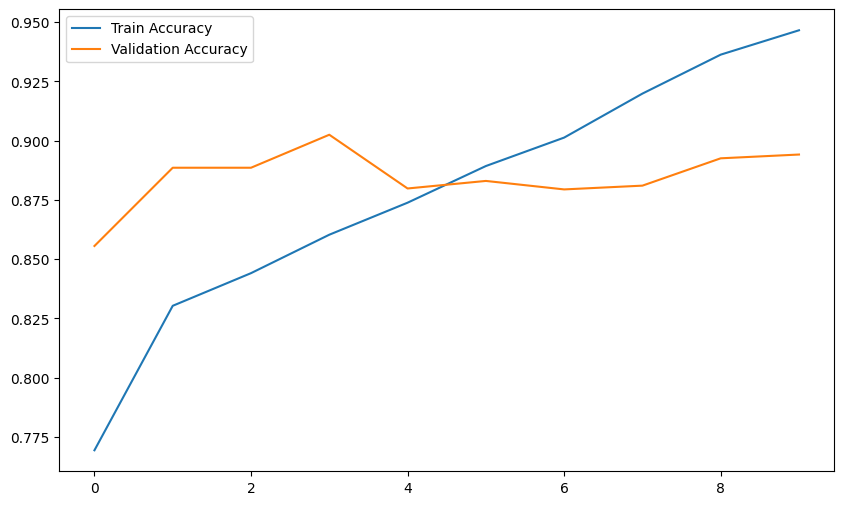

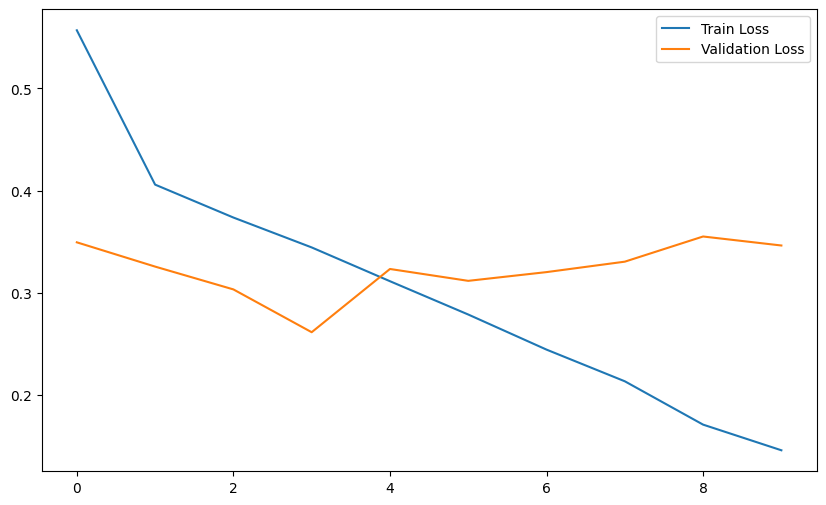

In [8]:
# Training Visualization
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label="Train Accuracy")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=[10,6])
plt.plot(hist.history['loss'], label="Train Loss")
plt.plot(hist.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [11]:
# Prediction Function
def predict_fun(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224)) / 255.0  # Normalize
    img_resized = np.reshape(img_resized, (1, 224, 224, 3))

    prediction = model.predict(img_resized)
    result = np.argmax(prediction)

    class_labels = ['ORGANIC', 'RECYCLABLE']  # Get class names from dataset

    plt.figure(figsize=(6,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Predicted: {class_labels[result]}', fontsize=14)
    plt.show()
    print(f'The image shown is {class_labels[result]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


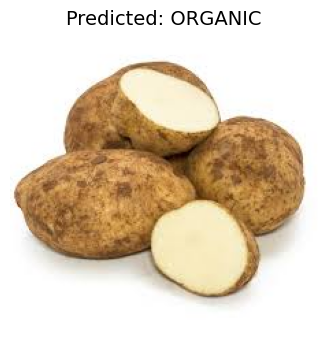

The image shown is ORGANIC
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


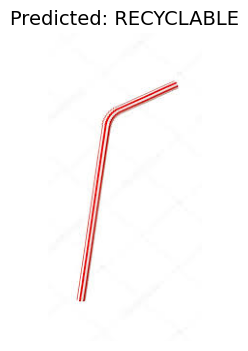

The image shown is RECYCLABLE


In [12]:
# Test Predictions
predict_fun("/content/O_12824.jpg")
predict_fun("/content/R_10413.jpg")